In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from TargetDistributions.DoubleWell import DoubleWellEnergy
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
from FittedModels.Utils.plotting_utils import plot_distributions, plot_distributions, plot_samples, \
    plot_sampling_info, plot_divergences, plot_history
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from TargetDistributions.MoG import MoG
from TargetDistributions.Guassian_FullCov import Guassian_FullCov
from FittedModels.Models.DiagonalGaussian import DiagonalGaussian
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D, plot_distribution, plot_samples_single_dist
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
import matplotlib.pyplot as plt
from TargetDistributions.MoG import MoG
from TargetDistributions.MoG import custom_MoG
from FittedModels.Utils.plotting_utils import plot_samples_vs_contours
torch.set_default_dtype(torch.float64)

In [4]:
target = DoubleWellEnergy(2, a=-0.5, b=-6)

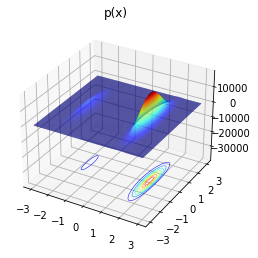

In [5]:
dist = plot_distribution(target, bounds=[[-3, 3], [-3, 3]], n_points=300)

# Let's fit with KL

In [6]:
dim=2
n_samples_estimation = int(1e5)
batch_size=int(1e3)
epochs=int(1e4)
torch.manual_seed(0) # 0
train_prior = True
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=20, scaling_factor=2.0, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl", lr=1e-3) 
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

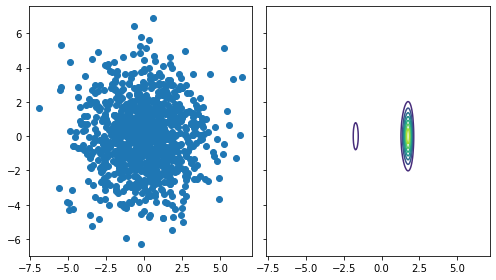

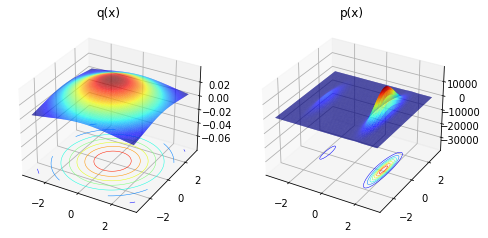

In [7]:
plot_samples_vs_contours(tester, n_samples=1000) # this will also now do data dependent init for ActNorm
plot_distributions(tester, bounds=[[-3, 3], [-3, 3]], n_points=100)

loss: -12.080616419865098, mean log p_x -3.32856444372314: 100%|██████████| 200/200 [00:22<00:00,  8.94it/s]  


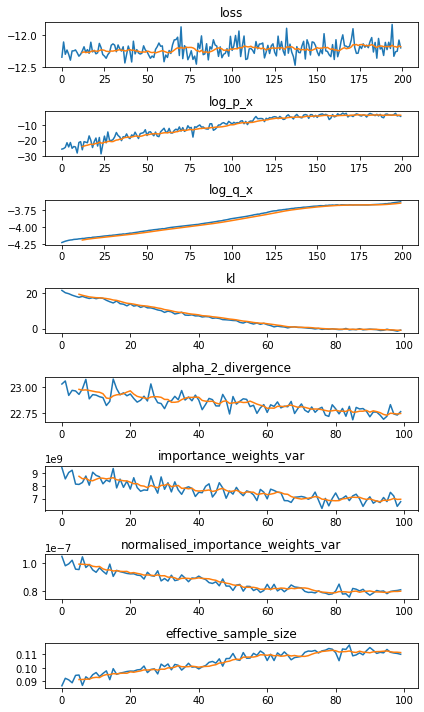

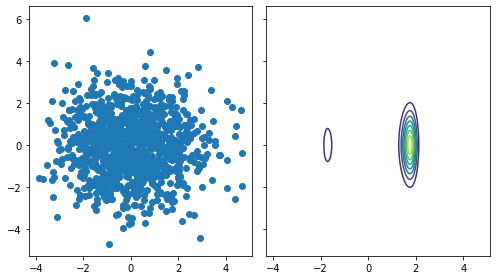

In [8]:
if train_prior:
    history_prior = tester.train_prior(epochs=200, batch_size=batch_size, lr=0.01)
    plot_history(history_prior)
    plot_samples_vs_contours(tester)
    expectation_prior_trained, info_prior = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: -0.62641506488043, mean log p_x -2.9987869462287393:   0%|          | 0/10000 [00:00<?, ?it/s]

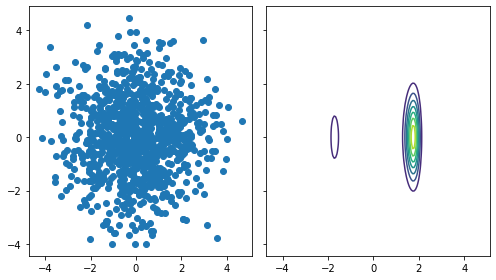

loss: -4.809523097197549, mean log p_x 1.670323419119876:  10%|▉         | 999/10000 [01:25<12:26, 12.05it/s]   

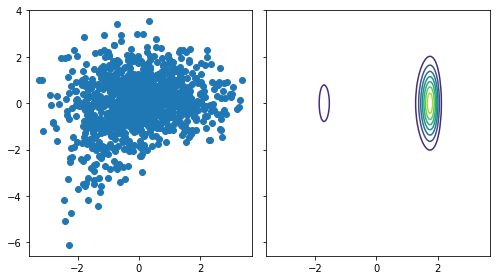

loss: -6.325637965163148, mean log p_x 3.3103713335013594:  20%|█▉        | 1999/10000 [02:52<11:08, 11.96it/s] 

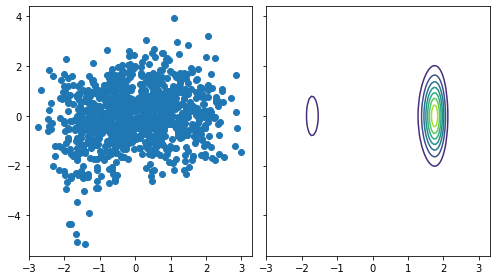

loss: -6.992935235022738, mean log p_x 3.884830183245752:  30%|██▉       | 2999/10000 [04:19<10:08, 11.51it/s] 

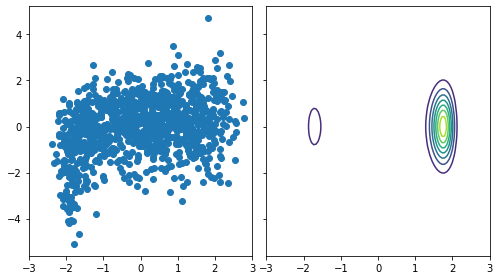

loss: -8.292235353804084, mean log p_x 5.2875628599657505:  40%|████      | 4000/10000 [05:57<08:18, 12.04it/s]

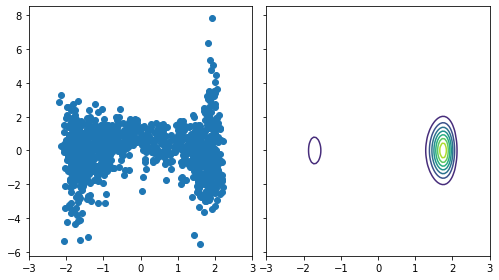

loss: -8.571774824916028, mean log p_x 5.677651485283401:  50%|█████     | 5000/10000 [07:25<07:12, 11.55it/s] 

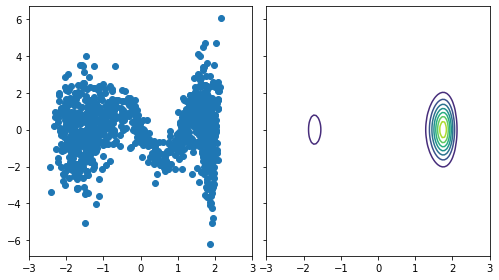

loss: -8.594216728390252, mean log p_x 5.7177435044712475:  60%|██████    | 6000/10000 [09:02<06:27, 10.33it/s]

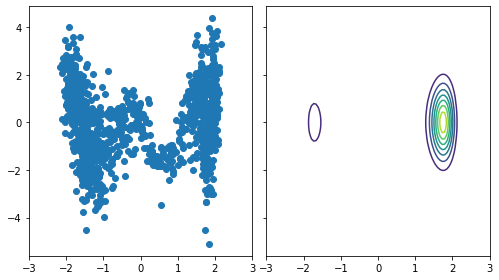

loss: -8.485171953514115, mean log p_x 5.545131117966106:  70%|███████   | 7000/10000 [10:32<05:12,  9.61it/s] 

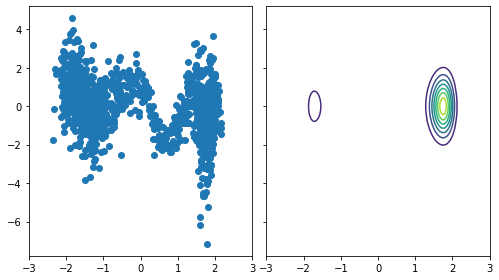

loss: -8.464784982412457, mean log p_x 5.58901246619218:  80%|████████  | 8000/10000 [12:21<03:31,  9.47it/s] 

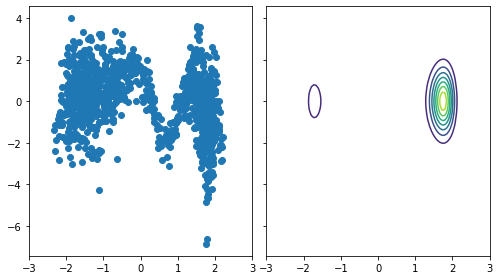

loss: -8.022487384384453, mean log p_x 5.602696948141223:  90%|█████████ | 9000/10000 [14:09<01:46,  9.42it/s] 

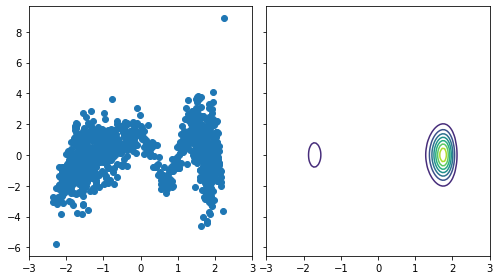

loss: -8.328495786238747, mean log p_x 5.531545392017994: 100%|██████████| 10000/10000 [15:54<00:00, 10.47it/s]


In [9]:
history = tester.train(epochs, batch_size=batch_size, 
                       intermediate_plots=True, plotting_func=plot_samples_vs_contours,
                       clip_grad_norm=True, max_grad_norm=1)#, clip_grad_max=True, max_grad_value=0.5)

In [11]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n"
      f"effective sample size before is {info_before['effective_sample_size'] / n_samples_estimation}\n"
      f"effective sample size after train is {info['effective_sample_size'] / n_samples_estimation}\n"
      f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

if train_prior:
    print(f"estimate after prior training is {expectation_prior_trained} \n"
        f"effective sample size trained prior is {info_prior['effective_sample_size'] / n_samples_estimation}\n")

estimate before training is 12.910956032901932 
estimate after training is 12.822461769685473 
effective sample size before is 0.08957001501889808
effective sample size after train is 0.16413374557874594
variance in weights is 5.092643260044124e-10


NameError: name 'expectation_prior_trained' is not defined

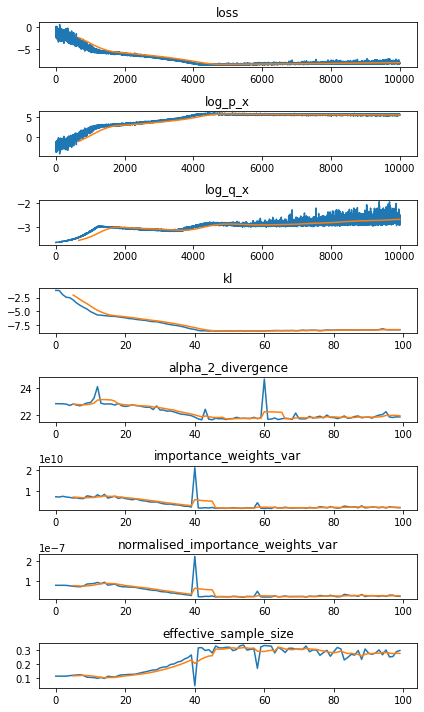

In [12]:
plot_history(history)

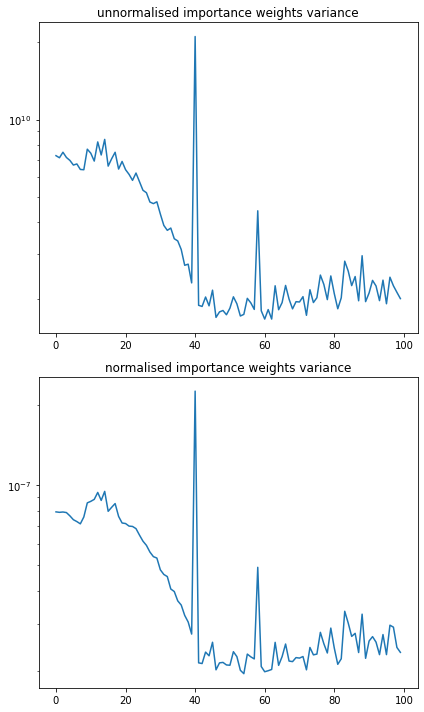

In [13]:
plot_sampling_info(history)

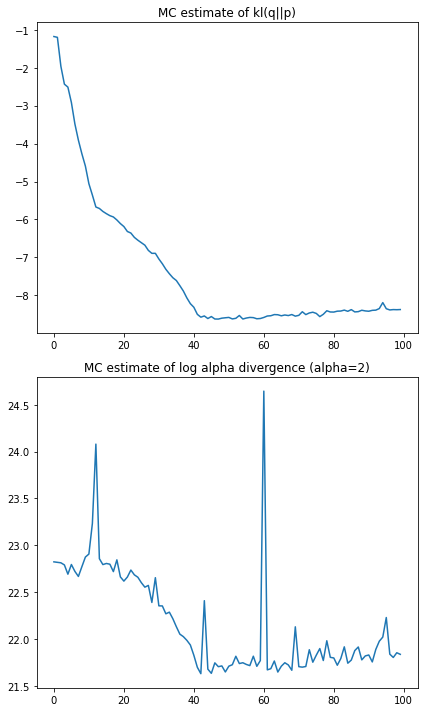

In [14]:
plot_divergences(history)

In [19]:
try:
    plot_distributions(tester, bounds=[[-3, 3], [-3, 3]], n_points=100)
except:
    print("coudln't plot on grid")

coudln't plot on grid


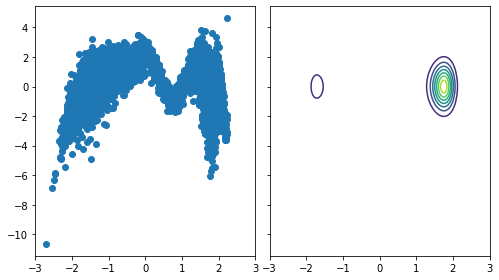

In [25]:
plot_samples_vs_contours(tester, n_samples=5000) 

# Let's fit with alpha divergence

In [38]:
dim=2
n_samples_estimation = int(1e5)
batch_size = int(1e3) 
epochs = int(1e4)
train_prior=True
lr = 3e-4
torch.manual_seed(0) 
#learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=20, scaling_factor=2.0, trainable_prior=True, flow_type="IAF")
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=20, scaling_factor=2.0, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=lr, 
                                   weight_decay=1e-6) 
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

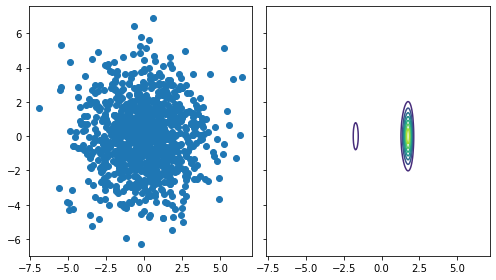

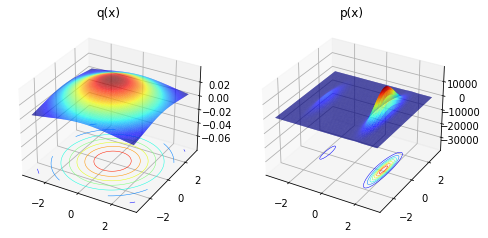

In [39]:
plot_samples_vs_contours(tester, n_samples=1000) # this will also now do data dependent init for ActNorm
plot_distributions(tester, bounds=[[-3, 3], [-3, 3]], n_points=100)

loss: -12.080616419865098, mean log p_x -3.32856444372314: 100%|██████████| 200/200 [00:22<00:00,  9.07it/s]  


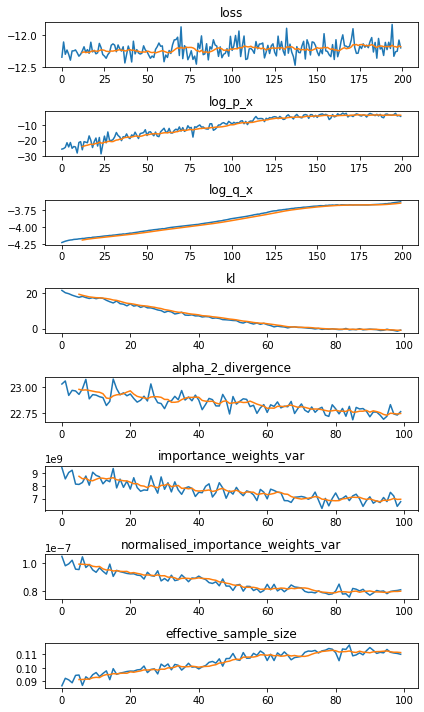

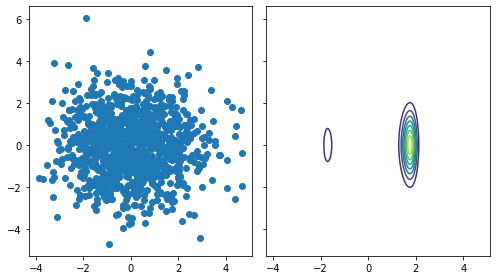

In [40]:
if train_prior:
    history_prior = tester.train_prior(epochs=200, batch_size=batch_size, lr=0.01)
    plot_history(history_prior)
    plot_samples_vs_contours(tester)
    expectation_prior_trained, info_prior = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: -12.040625586976104, mean log p_x -3.3575833761682956:   0%|          | 0/10000 [00:00<?, ?it/s]

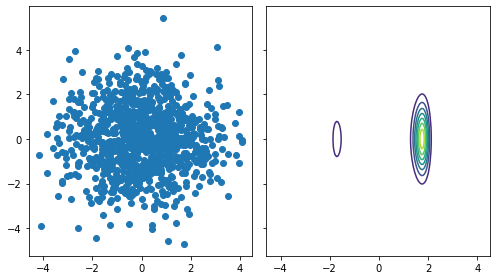

loss: -12.177835311924099, mean log p_x -2.616013612140903:  10%|█         | 1000/10000 [02:22<27:39,  5.42it/s] 

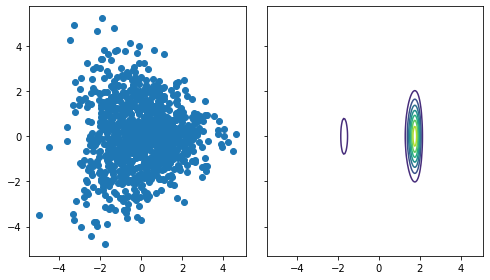

loss: -12.04656885008674, mean log p_x -2.4552803854125917:  20%|██        | 2000/10000 [05:08<22:23,  5.95it/s] 

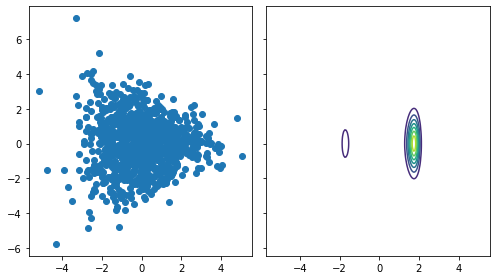

loss: -12.280662925107205, mean log p_x -1.5032158214023024:  30%|███       | 3000/10000 [07:55<18:12,  6.41it/s]

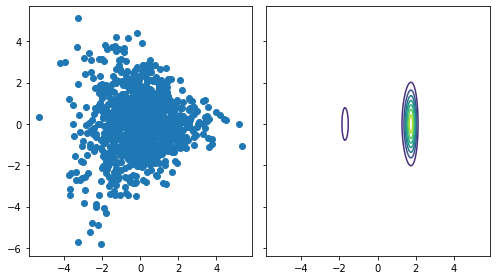

loss: -12.04284499091916, mean log p_x -3.031159758284885:  40%|████      | 4000/10000 [10:40<16:01,  6.24it/s]  

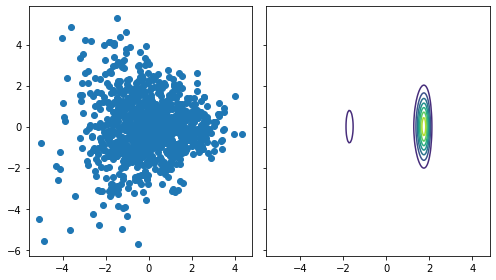

loss: -12.119635166942345, mean log p_x -1.8774081219091998:  50%|█████     | 5000/10000 [13:25<13:37,  6.12it/s]

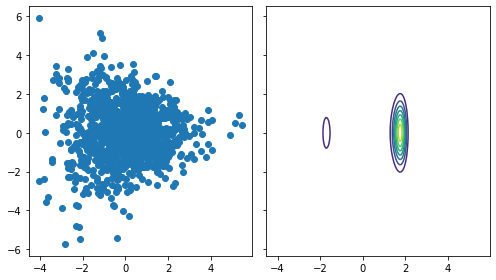

loss: -12.034508587482268, mean log p_x -3.49498301564931:  60%|██████    | 6000/10000 [16:10<10:38,  6.26it/s]  

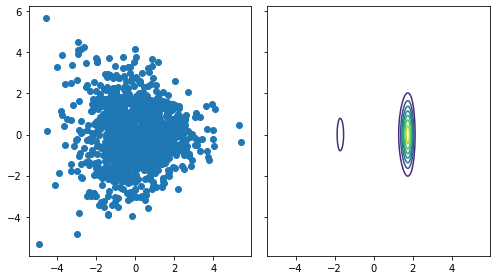

loss: -12.257186882525282, mean log p_x -1.2922201646402784:  70%|███████   | 7000/10000 [18:57<08:41,  5.75it/s]

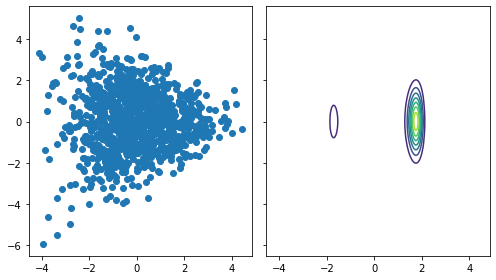

loss: -12.193637487895403, mean log p_x -1.7564249810301449:  80%|████████  | 8000/10000 [21:36<05:20,  6.24it/s]

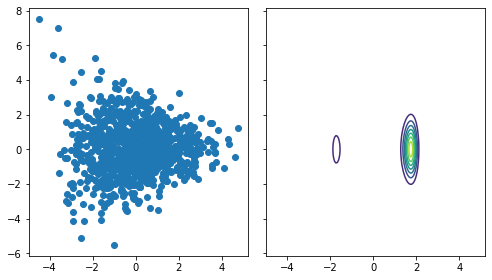

loss: -12.178976959042036, mean log p_x -3.1592674774142533:  90%|█████████ | 9000/10000 [24:17<02:07,  7.85it/s]

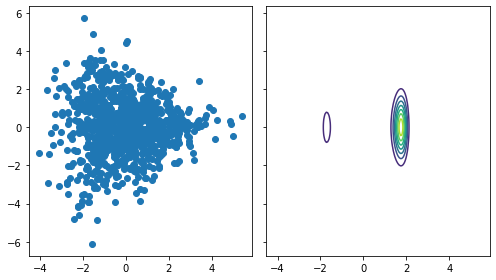

loss: -12.01210726522666, mean log p_x -2.138762675778615: 100%|██████████| 10000/10000 [26:28<00:00,  6.29it/s] 


In [41]:
history = tester.train(epochs, batch_size=batch_size, 
                       intermediate_plots=True, plotting_func=plot_samples_vs_contours,
                       clip_grad_norm=True, max_grad_norm=1)#, clip_grad_max=True, max_grad_value=0.5)

In [42]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n"
      f"effective sample size before is {info_before['effective_sample_size'] / n_samples_estimation}\n"
      f"effective sample size after train is {info['effective_sample_size'] / n_samples_estimation}\n"
      f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

if train_prior:
    print(f"estimate after prior training is {expectation_prior_trained} \n"
        f"effective sample size trained prior is {info_prior['effective_sample_size'] / n_samples_estimation}\n")

estimate before training is 12.910956032901932 
estimate after training is 13.206164597213345 
effective sample size before is 0.08957001501889808
effective sample size after train is 0.12891539003359895
variance in weights is 6.757093320452641e-10
estimate after prior training is 13.120715410328115 
effective sample size trained prior is 0.11259141498942946



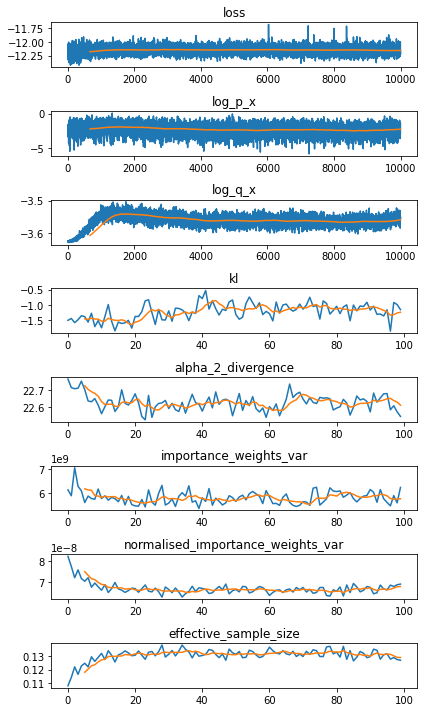

In [43]:
plot_history(history)

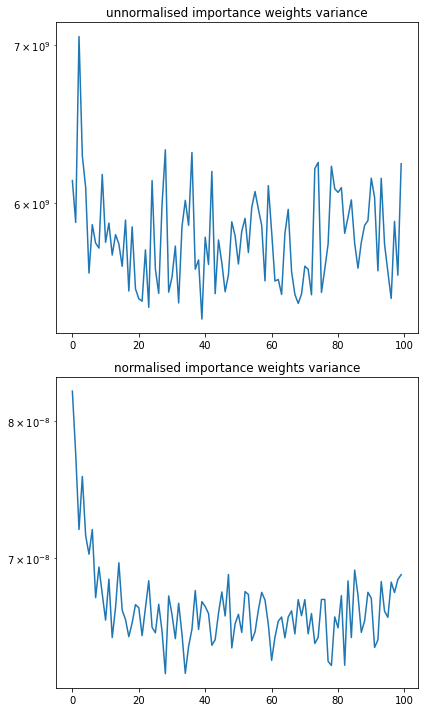

In [44]:
plot_sampling_info(history)

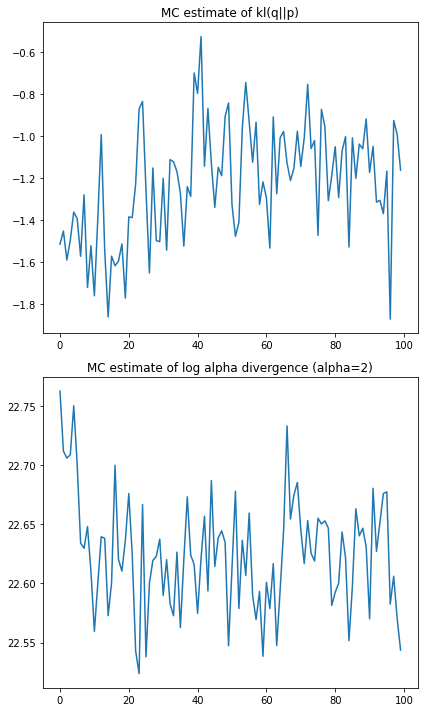

In [45]:
plot_divergences(history)

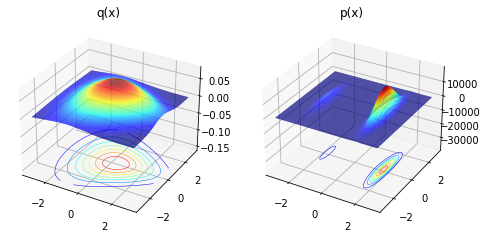

In [46]:
try:
    plot_distributions(tester, bounds=[[-3, 3], [-3, 3]], n_points=100)
except:
    print("coudln't plot on grid")

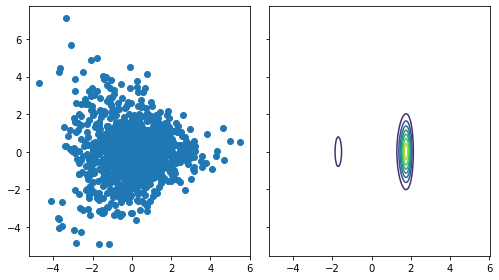

In [47]:
plot_samples_vs_contours(tester, n_samples=1000) 